In [1]:
# install dependancies 
!pip install -Uqq fastbook
!pip install duckduckgo_search==2.9.1
import fastbook
fastbook.setup_book()
from fastbook import *



  Obtaining dependency information for diskcache>=5.6.1 from https://files.pythonhosted.org/packages/3f/27/4570e78fc0bf5ea0ca45eb1de3818a23787af9b390c0b0a0033a1b8236f9/diskcache-5.6.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00


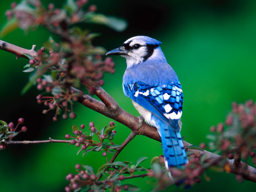

In [2]:
# fetch sample url for bird photos
urls = search_images_ddg('bird photos', max_images=1)
urls[0]

# save image to destination 
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0],dest, show_progress=False)

# view image 
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


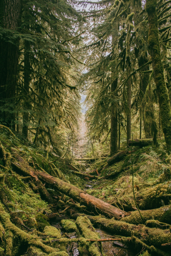

In [3]:
# fetch sample for forest photos 
forest_url = search_images_ddg('forest photos', max_images=1)[0]
dest = 'forest.jpg'
download_url(forest_url, dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [4]:
# create dataset for bird and forest photos
searches = ['forest','bird']
path = Path('bird_or_not')
from time import sleep

for x in searches : 
    dest = (path/x)
    dest.mkdir(exist_ok=True, parents=True)
    # simple photo
    urls = search_images_ddg(f'{x} photo')
    download_images(dest,urls = urls)
    sleep(10)
    # sun photo
    urls = search_images_ddg(f'{x} sun photo')
    download_images(dest,urls=urls)
    # shade photo 
    urls = search_images_ddg(f'{x} shade photo')
    download_images(dest,urls=urls)
    
    resize_images(path/x, max_size=400,dest=path/x)

    


In [5]:
# check for failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


30

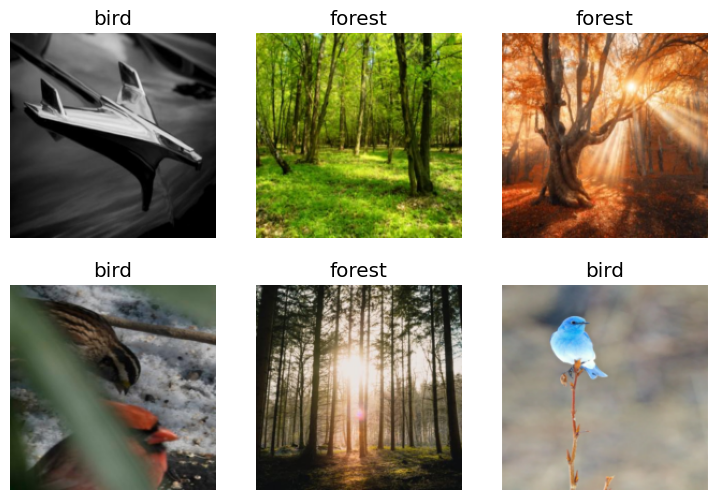

In [6]:
# using DataBlocks from fast ai to create DataLoaders for training neural net 

dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y = parent_label, 
    item_tfms = [Resize(192,method='squish')]
).dataloaders(path,bs=32)

'''
# using data loaders instead of datablocks 
def is_bird(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path,
    get_image_files(path),
    valid_pct=0.2,
    seed=42,
    label_func=is_bird,
    item_tfms= Resize(224)
)
'''

dls.show_batch(max_n=6)

In [7]:
learn = vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.490138,0.197751,0.040541,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.210099,0.119065,0.036036,01:23
1,0.100313,0.116370,0.040541,01:23
2,0.078516,0.101650,0.036036,01:23
3,0.050197,0.085435,0.036036,01:24
4,0.032427,0.090383,0.036036,01:23


In [8]:
img = PILImage.create('bird.jpg')
is_bird,_,probs = learn.predict(img)
print(f'This is a : {is_bird}')
print(f"Probability it's a bird: {probs[0].item():.6f}")




This is a : bird
Probability it's a bird: 1.000000
